# Algoritmos genéticos

Los algoritmos genéticos son algoritmos basados en conceptos biólogicos sobre la evolución. Son parte de los algoritmos evolutivos y se basan, precisamente, en la idea de que hay una evolución de los individuos a partir de diferentes procesos biólogicos: selección, reproducción, mutación, reemplazo.

Estos tipos de algoritmos pueden ser muy variados. Una versión simple de un algoritmo genético se presenta aquí para solucionar el problema de las 8 reinas.

### Creación del problema

El problema consistirá en colocar un número $k$ de piezas reinas en un tablero de ajedrez. Se colocaran con una configuración inicial en donde la mayoría de las reinas no se atacan y se buscará organizarlas en una configuración que permita que se ataquen la mayoría de las reinas.

Otra forma de configurar el problema es que se inicie en un estado dado aleatorio y de allí se parta a encontrar la solución donde las reinas no se ataquen. Aquí nos fijamos en principio en el primer problema.

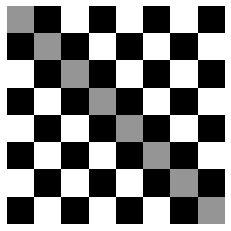

In [1]:
import numpy as np
from Queens import Board

#Crea el problema
board = Board(size=8)
board.put_pieces(num=8, init='line')

#Visualiza el problema
board.draw()

## Algoritmo genético simple

Para definir nuestro algoritmo genético, debemos definir varias funciones auxiliares, entre ellas la función de selección, reproducción, mutación, reemplazo y además la función fitness. La función fitness es central en los algoritmos genéticos. 

Antes de pasar a definir estas funciones, definimos tres funciones auxiliares que nos ayudarán a implementar adecuadamente el algoritmo:

1. Obtención de población inicial (<tt>get_population</tt>): Genera genes de la forma: $$[p_1, p_2, p_3, \cdots, p_8]$$ donde cada $p_i$ es un número que representa la posición de la reina en esa columna (o 0 si no hay reina). De tal forma, si tenemos una reina en la posición $(2,3)$, tendremos que $p_2=3$.
2. Obtención de pesos probabilísticos (<tt>get_scores</tt>): Obtiene valores de probabilidad de los individuos en base a la función $p(x) = \frac{e^{f(x)}}{\sum_y e^{f(y)}}$ donde $f$ es la función fitness. De esta forma podemos elegir aleatoriamente individuos según su probabilidad (selección ruleta).
3. Dibuja la solución (<tt>get_board</tt>): Dibuja el tablero final a partir del vector individuo $[p_1, p_2, p_3, \cdots, p_8]$.

In [2]:
def get_population(s=7):
    """Genera una población de genes de tamaño s"""
    population = []
    for i in range(s):
        population.append(np.random.choice(8, size=8, replace=False)+1)
    return population

def get_scores(population, fitness_function):
    """Obtiene probabilidades a partir de la función fitness"""
    partition = 0
    probs = np.zeros(len(population))
    for i, subject in enumerate(population):
        score = fitness_function(subject)
        exp = np.exp(score)
        probs[i] = exp
        partition += exp
    
    return probs/partition

def get_board(array):
    """Dibuja la solución a partir de los genes"""
    new_board = Board(size=8)
    for x,y in enumerate(array):
        new_board.put(piece='Q', cell=(x,y-1))
        
    return new_board

### Función fitness

La función de fitness o función objetivo es una función
$f : I \to \mathbb{R}$, que asigna un valor numérico a un individuo en base a su capacidad. En
este caso, la capacidad estará determinada por qué tanto este individuo nos ayuda a
solucionar el problema.

Aquí tomamos una función que indica cuántas reinas se están atacando entre sí, y tomamos el valor menos para poder definir un problema de maximización. De esta forma, el valor máximo será igual a 0.

In [3]:
def fitness(array, s = 8):
    """Función fitness para el problema de 8 reinas"""
    matrix = np.zeros((s,s))
    for i,j in enumerate(array):
        matrix[i,j-1] = 1
    
    err = 0
    queens = np.stack(np.where(matrix == 1)).T
    for i,j in queens:
        for k in range(1,s+1):
            #Revisa la diagonal
            if i+k<s and j+k<s:
                if [i+k,j+k] in queens.tolist():
                    err += 1
            if i-k>=0 and j-k>=0: 
                if [i-k,j-k] in queens.tolist():
                    err += 1
            if i-k>=0 and j+k<s:
                if matrix[i-k, j+k] ==1:
                    err += 1
            if i+k<s and j-k>=0:
                if matrix[i+k, j-k] ==1:
                    err += 1
                    
            #Revisa las columnas
            if i+k<s:
                if matrix[i+k,j]== 1:
                    err += 1
            if i-k >= 0:
                if matrix[i-k,j]== 1:
                    err += 1
            
            #Revisa los renglones
            if j+k<s:
                if matrix[i,j+k]== 1:
                    err += 1
            if j-k >= 0:
                if matrix[i,j-k]== 1:
                    err += 1
    return -err

## Algoritmo genético

El algoritmo genético contará de otras cuatro funciones esenciales, las cuáles son:

1. Selección (<tt>selection</tt>): Selecciona los padres en base a un criterio. Aquí tomamos dos criterios:
    1. Selección ruleta: Selecciona de manera aleatoria en base a su fitness; los individuos con más fitness tendrán mayor probabilidad de ser seleccionados.
    2. Selección aleatoria: Culaquier par de individuos tiene la misma probabilidad de ser seleccionados.
2. Reproducción (<tt>reproduce</tt>): Dado los dos padres, esta función reproduce un descendiente mediante la reproducción en un punto. Los genes padres se cortan en un punto y se recombinan para formar el gen descendiente.
3. Mutación (<tt>mutate</tt>): Algunos de los individuos hijos pueden tener una mutación en sus genes (cambio de éstos) en base a una probabilidad pequeña.
4. Reemplazo (<tt>replacement</tt>): Reemplaza la antigua generación/población por una nueva. Aquí el reemplazo se hace mediante el fitness, los padres y los descendientes compiten y la siguiente generación tendrá al individuo con mayor fitness.

In [4]:
def selection(population, weights, size=2, method='Roulette'):
    """Función de selección"""
    if method == 'Roulette':
        idx1, idx2 = np.random.choice(range(len(population)), replace=False, size=size, p=weights)
        return population[idx1], population[idx2]
    elif method == 'Random':
        idx1, idx2 = np.random.choice(range(len(population)), replace=False, size=size)
        return population[idx1], population[idx2]

def reproduce(parent1, parent2):
    """Función de reproducción"""
    n = len(parent1)
    c = np.random.choice(range(n))
    return np.hstack((parent1[:c], parent2[c:]))

def mutate(array,p=0.5):
    """Función de mutación"""
    change = np.random.choice([0,1,2], p=[2/4,1/4,1/4])
    if change == 0:
        return array
    elif change == 1:
        v1 = np.random.choice(range(len(array)))
        array[v1] = (array[v1]+1)%8
        
        return array
    else:
        v1, v2 = np.random.choice(range(len(array)), size=2)
        c1 = array[v1]
        c2 = array[v2]
        array[v1] = c2
        array[v2] = c1
        
        return array
    
def replacement(candidates, fitness_function=fitness):
    """Función de reemplazo"""
    sorted_candidates = sorted([(ind, fitness_function(ind)) for ind in candidates], key=lambda x: x[1])
    
    return sorted_candidates[-1][0]

Finalmente, podemos ya implementar el algoritmo genético propiamente dicho. Este algoritmo cambiará las poblaciones hasta que encuentre un criterio que le permita seleccionar al individuo con mayor fitness en la última descendencia. Aquí el criterio es el número de iteraciones. El algoritmo consta en, dado una población inicial:

1. Obtenes los pesos para la selección de los padres.
2. Seleccionar a los padres en base a estos pesos.
3. Reproducirse para generar un descendiente.
4. El descendiente puede presentar alguna mutación.
5. Reemplzar la población previa, por la nueva población.

In [5]:
def genetic_algorithm(population, fitness_function=fitness, t=0):
    """Algoritmo genético"""
    #Obtiene pesos probabilísticos a partir de la función fitness
    weights = get_scores(population,fitness_function=fitness_function)
    #Guarda población descendiente
    population2 = []
    for i in range(len(population)):
        #Selecciona los padres (selección ruleta)
        parent1, parent2 = selection(population, weights, method='Roulette')
        #Reproduce a partir de los padres
        child = reproduce(parent1, parent2)
        #Muta genes en el hijo
        child = mutate(child)        
        #Reemplaza por la nueva población en base al fitness
        new_ind = replacement([child,parent1,parent2], fitness_function=fitness_function)
        population2.append(new_ind)
    
    if t == 100:
        #Si se cumple el criterio de detención, se visualiza la solución
        idx = np.argmax([fitness_function(subject) for subject in population2])
        get_board(population2[idx]).draw()
        print(fitness_function(population2[idx]))
    else:
        #En otro caso repite los pasos
        genetic_algorithm(population2, fitness_function=fitness_function, t=t+1)

### Aplicación al problema

Cuando aplicamos el algoritmo genético al problema de las 8 reinas, debemos codificar el tablero como una secuencia de genes, de la forma que ya lo hemos definido.

De esta forma, cada gen representará la posición de una reina en el tablero y la función fitness es el número de otras reinas a las que esta reina ataca. 

Para empezar, generamos una población aleatoria de tamaño s, es decir, s individuos cuyos genes representan configuraciones aleatorias del tablero. De esta forma, al aplicar el algoritmo genético vemos que terminas con una configuración que maximiza la función fitness; es decir, que maximiza el número de reinas que no se atacan entre sí.

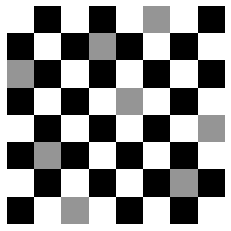

0


In [6]:
init_population = get_population(s=100)    
genetic_algorithm(init_population)